In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.fft import fft, fftfreq
import cv2

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    lowcut = lowcut / nyq
    highcut = highcut / nyq
    b, a = butter(order, [lowcut, highcut], btype='band', analog=False)
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function to compute optical flow using Farneback method
def compute_optical_flow(fixed_frame, moving_frame):
    # Convert to grayscale

    # Compute optical flow (Farneback method), 0.5, 3, 15, 3, 5, 1.2, 0)
    flow = cv2.calcOpticalFlowFarneback(fixed_frame, moving_frame, None, 0.5, 3, 25, 5,7, 1.5, 0)

    return flow

def create_circular_mask(frame, margin=20):
    """
    Detecta el contorno más grande, y crea una máscara siguiendo el contorno
    con un margen adicional para eliminar los bordes perpendiculares al contorno.
    """
    # Convertir la imagen a escala de grises
    
    # Aplicar un umbral para binarizar la imagen
    _, thresh = cv2.threshold(frame, 1, 255, cv2.THRESH_BINARY)
    
    # Encontrar los contornos en la imagen binarizada
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Si se encuentran contornos, continuar
    if contours:
        # Encontrar el contorno más grande
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Crear una máscara en blanco (todos los píxeles son 0)
        mask = np.zeros_like(frame[:, :], dtype=np.uint8)
        
        # Dibujar el contorno más grande en la máscara
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        
        # Dilatar el contorno para agregar un margen
        dilated_mask = cv2.erode(mask, None, iterations=margin)

        
        # Devolver la máscara dilatada que cubre el área del contorno con el margen
        return dilated_mask
    else:
        # Si no se encuentra un contorno, devolver None
        return None




In [1]:
import glob
import natsort
general_path = '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/'
ob1_files = glob.glob(general_path+'./LabelDataObstetrics/*.mat')
ob1_files = natsort.natsorted(ob1_files)
#split ob1_files.split('/')
patient_t=[]
sweep_t=[]
for i in range(len(ob1_files)):
    sweep_t.append(ob1_files[i].split('/')[-1].split('.')[0])
    #check if ob1_files[i] has word copy, if so remove it
    if 'copy' in sweep_t[i]:
        sweep_t[i]=sweep_t[i].split(' copy')[0]
    patient=sweep_t[i][0:3]
    #if patient has letter _ in it, remove it and add a 0 start
    patient = '0'+patient if '_' in patient else patient
    patient=patient.split('_')[0]
    patient_t.append(patient)
print(ob1_files)
print(patient_t)
print(sweep_t)

['/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/002_sweep1 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/002_sweep4 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/002_sweep5 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/007_sweep1 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/008_sweep1 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/008_sweep7 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/010_sweep2 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/025_sweep4 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDa

In [ ]:

import cv2
import numpy as np
import scipy.io as sio
import skvideo.io as skv
import torchio as tio
from skimage.transform import resize
import os
import sys
import matplotlib.pyplot as plt
import skimage.morphology as morph

from scipy.signal import stft, butter, filtfilt
src_path = os.path.join(general_path, 'src')
sys.path.append(src_path)

#import overlay_video from src/utils/overlay_video.py assuming that the file is in the same directory
from utils.overlay_video import generate_overlay_video,generate_overlay_video_with_plot


#for i in range(0,len(ob1_files)):
for i in range(2,3):#0,1
    mp4_file_path = general_path+'./Study/'+patient_t[i]+'/'+sweep_t[i]+'.mp4'
    print(mp4_file_path)
    coordinates = sio.loadmat(general_path+'./crop_coordinates/'+patient_t[i]+'.mat')
    #substract 1 to coordinates to match python indexing
    x1 = coordinates['x1'][0][0]-1
    x2 = coordinates['x2'][0][0]
    y1 = coordinates['y1'][0][0]-1
    y2 = coordinates['y2'][0][0]

    width = x2-x1
    height = y2-y1

    ob = sio.loadmat(ob1_files[i])['labels']
    ob=np.moveaxis(ob, 2, 0)

    cap = cv2.VideoCapture(mp4_file_path)
    #print fps
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(fps)
    #join every frame as an array
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    gt_video = np.array(frames)
    gt_original = gt_video.copy()

    # print(gt_video.shape)
    # print(ob.shape)
    # print('width: ',width)
    # print('height: ',height)
    diff = gt_video[1:,:,:,0]-gt_video[:-1,:,:,0]
    diff_sum=np.sum(diff,axis=(1,2))
    #normalize diff_sum
    diff_sum = diff_sum/np.max(diff_sum)

    # Assuming diff_sum is your normalized data array from the plot
    # Example: diff_sum = np.array([...])  # Replace with your actual array
    threshold = 0.2

    # Detect indices where diff_sum crosses above the threshold
    first_frame = np.where(diff_sum > threshold)[0][0]  # First upward crossing
    last_frame = np.where(diff_sum > threshold)[0][-1]  # Last upward crossing (before drop)

    #if from last_frame to the end is mask ob is not zero, last_frame is the last frame where mask is not zero
    for j in range(last_frame,diff.shape[0]):
        if np.sum(ob[j]) != 0:
            last_frame = j

    #if from start to first_frame is mask ob is not zero, first_frame is the first frame where mask is not zero
    #in this case the for is in reverse
    for j in range(first_frame,0,-1):
        if np.sum(ob[j]) != 0:
            first_frame = j


    # Obtener los límites del área de interés
    # row_limits, col_limits = np.where(morph.remove_small_objects(diff[first_frame+50].astype(bool), min_size=100) > 0)
    # y1, y2 = row_limits.min(), row_limits.max()
    # x1, x2 = col_limits.min(), col_limits.max()

    #check first if ob shape is the same as gt_video

    if ob.shape[1] != gt_video.shape[1] or ob.shape[2] != gt_video.shape[2]:
        #check width with ob.shape[2] and height with ob.shape[1]
        if width != ob.shape[2] or height != ob.shape[1]:
            # print('width and height are not the same')
            # print('width: ',width)
            # print('height: ',height)
            # print('gt: ', gt_video.shape)
            # print('ob: ',ob.shape)
            gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
            ob = ob[first_frame:last_frame, :,:]
            #calculate padding or cropping for height (dim 1)
            pad_or_crop_h = (gt_video.shape[1] - ob.shape[1])
            pad_h_before = max(0, pad_or_crop_h // 2)
            pad_h_after = max(0, pad_or_crop_h - pad_h_before)
            crop_h_before = max(0, -pad_or_crop_h // 2)
            crop_h_after = max(0, -pad_or_crop_h - crop_h_before)

            #calculate padding or cropping for width (dim 2)
            pad_or_crop_w = (gt_video.shape[2] - ob.shape[2])
            pad_w_before = max(0, pad_or_crop_w // 2)
            pad_w_after = max(0, pad_or_crop_w - pad_w_before)
            crop_w_before = max(0, -pad_or_crop_w // 2)
            crop_w_after = max(0, -pad_or_crop_w - crop_w_before)

            #apply padding if needed
            if pad_h_before > 0 or pad_h_after > 0 or pad_w_before > 0 or pad_w_after > 0:
                ob = np.pad(ob, 
                                ((0, 0), 
                                (pad_h_before, pad_h_after), 
                                (pad_w_before, pad_w_after)), 
                                'constant')
                
            #apply cropping if needed
            if crop_h_before > 0 or crop_h_after > 0 or crop_w_before > 0 or crop_w_after > 0:
                ob = ob[:, crop_h_before:ob.shape[1] - crop_h_after, crop_w_before:ob.shape[2] - crop_w_after]

            

        else:
            # Recortar el área de interés
            gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
            ob = ob[first_frame:last_frame, :,:]

    else:
        # Recortar el área de interés
        gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
        ob = ob[first_frame:last_frame, y1:y2,x1:x2]

    non_empty_frames = np.where(np.any(ob > 0, axis=(1, 2)))[0]
    ob=ob[non_empty_frames]
    gt_video=gt_video[non_empty_frames]

    resultant=(ob > 0).astype(int)*gt_video

    intensities = np.sum(gt_video>0, axis=(1, 2))
    #normalizing intensities
    intensities = intensities/np.max(intensities)
    intensity_local = np.sum(resultant>0, axis=(1, 2))/np.sum(ob>0, axis=(1, 2))


    num_classes = 2  # Número de clases
    # Crear la versión one-hot encoded
    one_hot = np.eye(num_classes)[ob]  # Esto genera el one-hot encoding
    # Verificar el nuevo shape
    # print(one_hot.shape) 
    #generate_overlay_video_with_plot(gt_video, one_hot,intensities,intensity_local, fps=30, output_video=general_path+'data/freq/'+sweep_t[i]+'_overlay.avi',gt_w=True)
    
    print(i)

    # Extraer la señal 1D del ROI: por ejemplo, la intensidad media de cada frame
    #signal = gt_video.mean(axis=(1,2))
    signal=np.sum(resultant>0, axis=(1, 2))/np.sum(ob>0, axis=(1, 2))
    #delete dc component
    signal = signal - np.mean(signal)

    print(ob.shape)

    
    

/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/002/002_sweep5.mp4
25.397265977378392
2
(146, 1053, 1219)


449
638


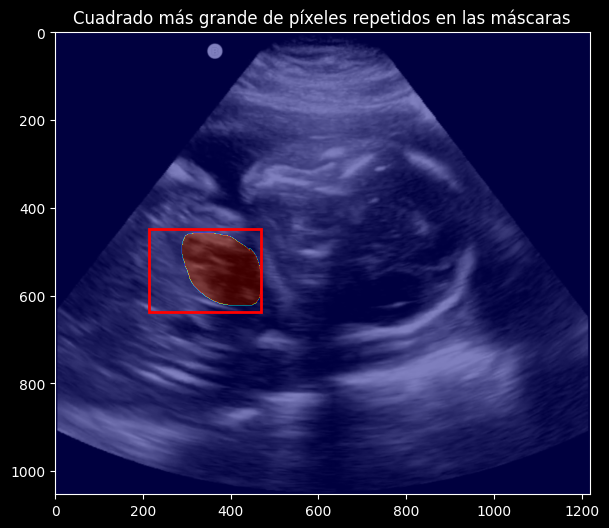

In [4]:
import matplotlib.patches as patches
# Calcular el centro de la máscara en cada frame donde haya información
centers = []
rows_min = []
rows_max = []
cols_min = []
cols_max = []
max_value = 0
id_max = 0
for i in range(ob.shape[0]):
    mask_i = ob[i]
    # Solo considerar frames con segmentación (máscara no vacía)
    if np.sum(mask_i) > 0:
        # Obtener las posiciones de las columnas donde la máscara es positiva
        row, cols = np.where(mask_i > 0)
        centers.append(np.mean(cols))
        rows_min.append(row.min())
        rows_max.append(row.max())
        cols_min.append(cols.min())
        cols_max.append(cols.max())
        if cols.max() > max_value:
            max_value = cols.max()
            id_max = i

if len(centers) > 0:
    # Calcular el centro promedio a lo largo de todos los frames
    col_center = int(np.mean(centers))
else:
    # En caso de que ninguna máscara tenga segmentación, usar la columna central del frame
    col_center = gt_video.shape[2] // 2

# Definir la ventana de columnas a extraer (por ejemplo, 10 columnas centradas en col_center)
window_size = 10
half_window = window_size // 2
col_start = max(0, col_center - half_window)
col_end = min(gt_video.shape[2], col_center + half_window)
col_start=min(cols_min)
col_end=max(cols_max)
row_start=min(rows_min)
row_end=max(rows_max)
# Visualizar un frame de ejemplo con la región extraída marcada
sample_frame_index = id_max
sample_frame = gt_video[sample_frame_index, :, :]
print(min(rows_min))
print(max(rows_max))

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(sample_frame, cmap='gray')
ax.imshow(ob[sample_frame_index], alpha=0.5, cmap='jet')

# Dibujar el cuadrado encontrado
rect = patches.Rectangle((col_start, row_start), col_end - col_start, row_end - row_start, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.set_title('Cuadrado más grande de píxeles repetidos en las máscaras')
plt.show()


In [ ]:
import cv2
import imageio
import numpy as np

start_point = (col_start,row_start)
end_point   = (col_end,row_end)

frames_with_rect = []
for frame in gt_video:
    # Convertir el frame a color si está en escala de grises
    if len(frame.shape) == 2:
        frame_color = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    else:
        frame_color = frame.copy()
    
    # Dibujar el rectángulo sobre el frame.
    # Recuerda: en OpenCV, las coordenadas se expresan como (columna, fila)
    # Dibujar el rectángulo en color rojo (BGR: (0, 0, 255)) con grosor 2
    cv2.rectangle(frame_color, start_point, end_point, (0, 0, 255), thickness=2)
    
    # Convertir de BGR a RGB para que se muestre correctamente en el GIF
    frame_rgb = cv2.cvtColor(frame_color, cv2.COLOR_BGR2RGB)
    frames_with_rect.append(frame_rgb)

# Crear y guardar el GIF (ajusta el fps según desees)
gif_filename = 'video_with_square1.gif'
imageio.mimsave(gif_filename, frames_with_rect, fps=10)
print(f"GIF guardado como {gif_filename}")

analisis_gt=gt_video[:,row_start:row_end,col_start:col_end]
ob_analisis=ob[:,row_start:row_end,col_start:col_end]

analisis_gt=analisis_gt*ob_analisis


GIF guardado como video_with_square1.gif


GIF saved as optical_flow_with_rect.gif


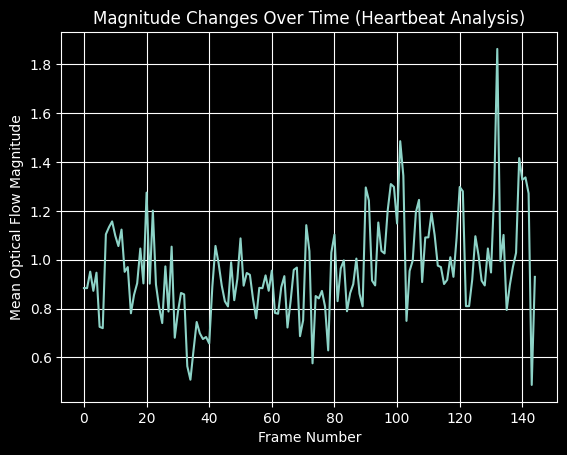

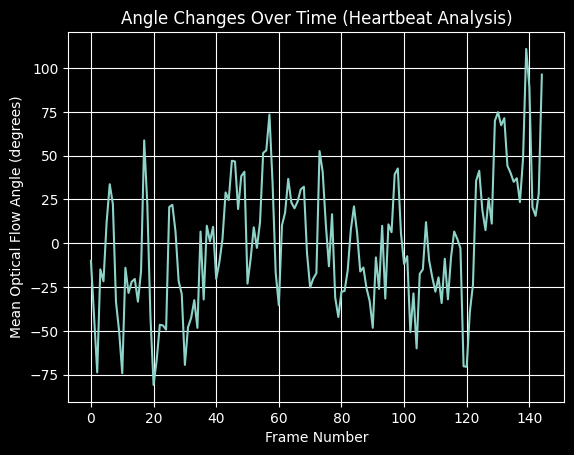

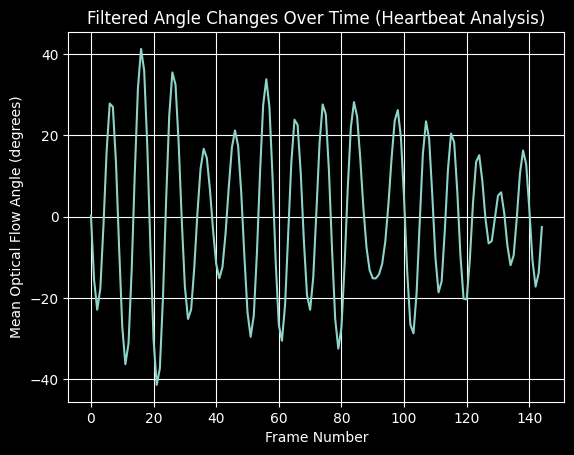

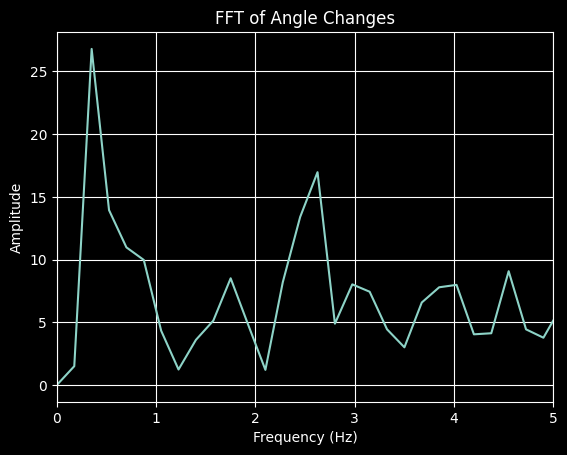

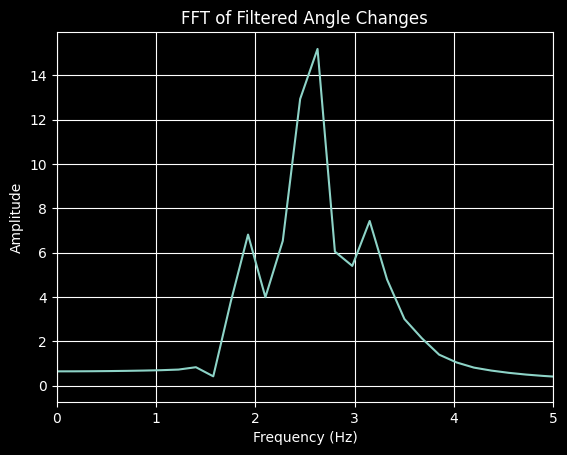

Frequency with highest amplitude (Hz): 2.627303376970179
Corresponding BPM: 157.63820261821076


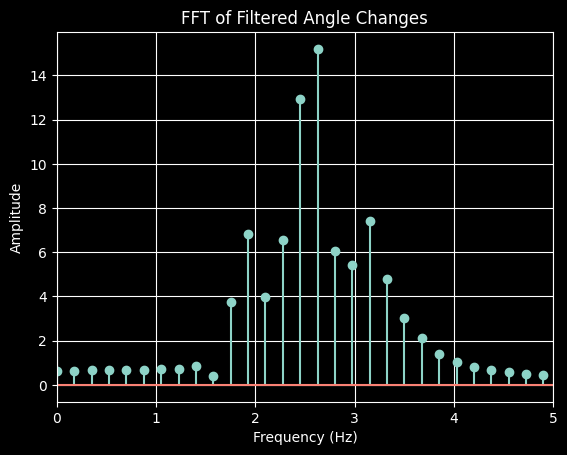

In [ ]:
import numpy as np
import cv2



margin = 12  # Margin for the circular mask


# Example: Assume gt_video is already loaded as a numpy array (shape: (frames, height, width, channels))
# For example: gt_video = np.random.rand(140, 480, 640, 3)  # a random video with 140 frames, 480x640 resolution
frames_with_flow = []
magnitude_changes = []
angle_changes = []
optical_flow_results = []
frames=gt_video.shape[0]
#print(analisis_gt.shape)
for i in range(1, frames):
    # Extract the region of interest from the current frame and the next frame
    frame1 = analisis_gt[i - 1]
    frame2 = analisis_gt[i]

    mask = create_circular_mask(frame1, margin)
    mask=mask/255
    
    # Compute optical flow between consecutive frames
    flow = compute_optical_flow(frame1, frame2)
    #flow= flow * mask[..., np.newaxis]  # Apply the mask to the flow
    # Visualize the optical flow using HSV coloring
     # Create an HSV image with 3 channels (height, width, 3)
    hsv = np.zeros((frame1.shape[0], frame1.shape[1], 3), dtype=np.uint8)
    
    # Convert flow to magnitude and angle
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    mag=mag*ob_analisis[i-1]
    ang=ang*ob_analisis[i-1]
    mag=mag*mask
    ang=ang*mask

    #Eliminar las áreas de fondo (donde la magnitud es 0)
    non_zero_mask = mag > 0  # Crear una máscara para las áreas donde la magnitud no es cero

    # Filtrar los valores de magnitud y ángulo utilizando la máscara
    mag_fil = mag[non_zero_mask]
    ang_fil = ang[non_zero_mask]
    # #reshape to the same size as the mask
    # # Store the mean magnitude of the flow in the ROI
    mean_magnitude = np.mean(mag_fil)
    magnitude_changes.append(mean_magnitude)

    # Store the mean angle of the flow in the ROI (convert angle to degrees)
    mean_angle = np.mean(ang_fil) * 180 / np.pi  # Convert radians to degrees
    angle_changes.append(mean_angle)


    # Plot polar graph with magnitude and angle
    # fig = plt.figure(figsize=(6, 6))
    # ax = fig.add_subplot(111, projection='polar')

    # # Use polar coordinates for magnitude and phase
    # ax.scatter(ang.flatten(), mag.flatten(), c='r', s=1, alpha=0.5)  # scatter plot of magnitude vs angle
    # ax.set_title(f'Frame {i} - Optical Flow', va='bottom')
    # ax.set_xlabel('Phase (Angle)')
    # ax.set_ylabel('Magnitude')
    # plt.show()



    
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue corresponds to the direction of flow
    hsv[..., 1] = 255  # Saturation is full
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value corresponds to the magnitude
    flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Convert grayscale frames to BGR to overlay the flow visualization
    frame1_bgr = cv2.cvtColor(frame1, cv2.COLOR_GRAY2BGR)
    frame2_bgr = cv2.cvtColor(frame2, cv2.COLOR_GRAY2BGR)

    # Overlay optical flow on the frame
    flow_with_overlay = cv2.addWeighted(frame2_bgr, 0.7, flow_rgb, 0.3, 0)
    
    # Draw a red rectangle over the region of interest
    #cv2.rectangle(flow_with_overlay, start_point, end_point, (0, 0, 255), thickness=2)
    
    # Convert from BGR to RGB for correct GIF rendering
    frame_rgb = cv2.cvtColor(flow_with_overlay, cv2.COLOR_BGR2RGB)
    frames_with_flow.append(frame_rgb)

# Create and save the GIF (adjust fps as desired)
gif_filename = 'optical_flow_with_rect.gif'
imageio.mimsave(gif_filename, frames_with_flow, fps=10)
print(f"GIF saved as {gif_filename}")

# Plot the mag changes over time
plt.plot(magnitude_changes)
plt.xlabel('Frame Number')
plt.ylabel('Mean Optical Flow Magnitude')
plt.title('Magnitude Changes Over Time (Heartbeat Analysis)')
plt.grid(True)
plt.show()

#delete dc component
angle_changes= angle_changes - np.mean(angle_changes)

# Plot the angle changes over time
plt.plot(angle_changes)
plt.xlabel('Frame Number')
plt.ylabel('Mean Optical Flow Angle (degrees)')
plt.title('Angle Changes Over Time (Heartbeat Analysis)')
plt.grid(True)
plt.show()


# Define the frequency range in bpm
low_bpm = 100   # Lower bound (60 bpm)
high_bpm = 200  # Upper bound (200 bpm)

# Convert bpm to Hz
lowcut = low_bpm / 60.0  # Convert to Hz
highcut = high_bpm / 60.0  # Convert to Hz

# Define the sampling frequency (fps)
fs = fps  # Assuming you have already defined this

# Apply the bandpass filter to the angle changes
filtered_angle_changes = bandpass_filter(angle_changes, lowcut, highcut, fs, order=5)


# Plot the filtered angle changes over time
plt.figure()
plt.plot(filtered_angle_changes)
plt.xlabel('Frame Number')
plt.ylabel('Mean Optical Flow Angle (degrees)')
plt.title('Filtered Angle Changes Over Time (Heartbeat Analysis)')
plt.grid(True)
plt.show()


#plot fft of filtered_angle_changes
N = len(angle_changes)
T = 1.0 / fps
yf = fft(angle_changes)

xf = fftfreq(N, T)[:N//2]
plt.figure()
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.title('FFT of Angle Changes')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 5)
plt.show()


#plot fft of filtered_angle_changes
N = len(filtered_angle_changes)
T = 1.0 / fps
yf = fft(filtered_angle_changes)

xf = fftfreq(N, T)[:N//2]
plt.figure()
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.title('FFT of Filtered Angle Changes')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 5)
plt.show()

#obtain the max frequency and convert to bpm based on my sampling rate
from scipy.signal import find_peaks
# Find peaks in the FFT result
peaks, _ = find_peaks(2.0/N * np.abs(yf[0:N//2]), height=0.1)
# Get the frequencies corresponding to the peaks
peak_freqs = xf[peaks]
# Convert to BPM
peak_bpm = peak_freqs * 60
# Get the frequency with the highest amplitude
max_freq_index = np.argmax(2.0/N * np.abs(yf[0:N//2]))
max_freq = xf[max_freq_index]
max_bpm = max_freq * 60
print("Frequency with highest amplitude (Hz):", max_freq)
print("Corresponding BPM:", max_bpm)



plt.figure()
plt.stem(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.title('FFT of Filtered Angle Changes')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 5)
plt.show()

GIF saved as optical_flow_gt.gif


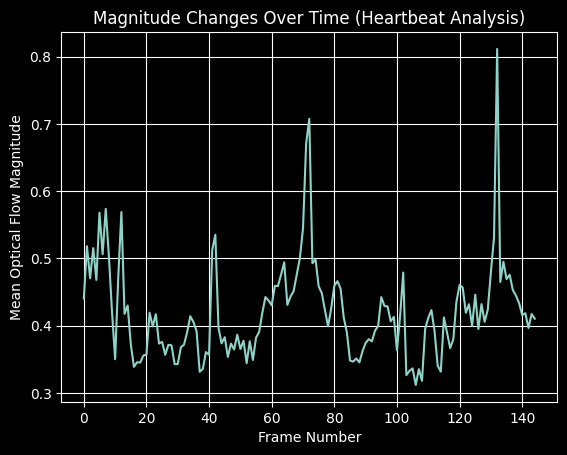

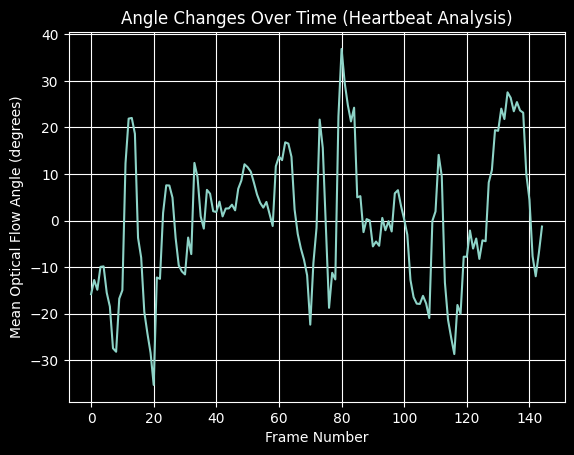

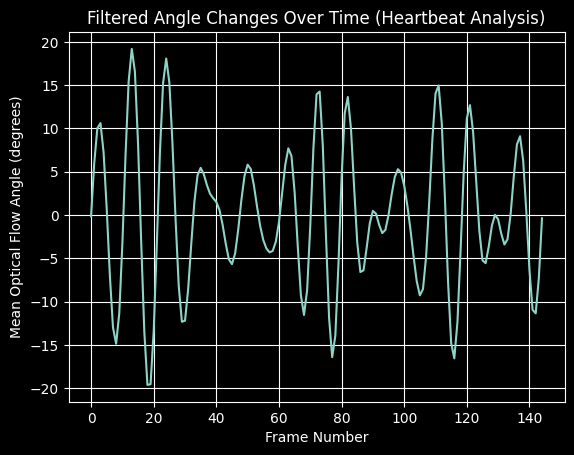

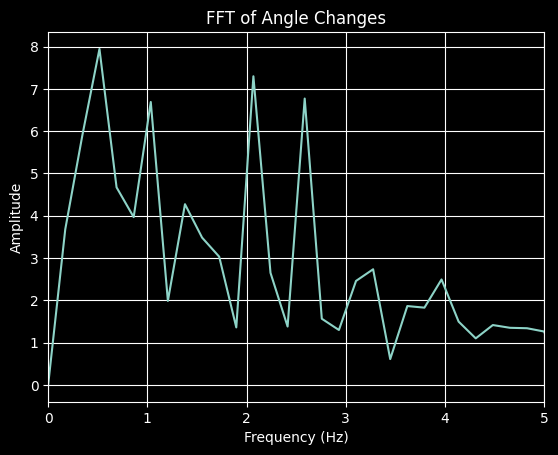

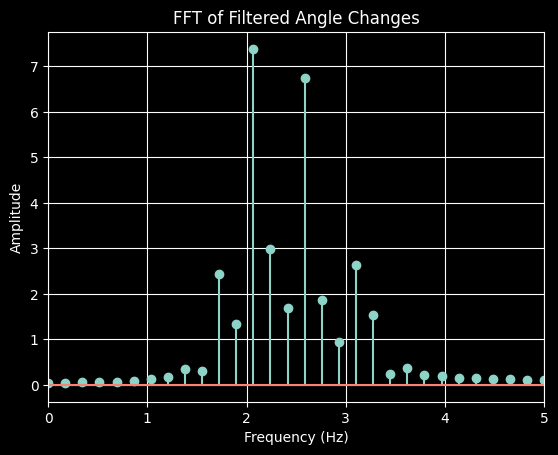

Frequency with highest amplitude (Hz): 2.0689655172413794
Corresponding BPM: 124.13793103448276


In [ ]:
import numpy as np
import cv2

# Function to compute optical flow using Farneback method
def compute_optical_flow(fixed_frame, moving_frame):
    # Convert to grayscale

    # Compute optical flow (Farneback method), 0.5, 3, 15, 3, 5, 1.2, 0)
    flow = cv2.calcOpticalFlowFarneback(fixed_frame, moving_frame, None, 0.5, 3, 30, 5,7, 1.5, 0)

    return flow


# Example: Assume gt_video is already loaded as a numpy array (shape: (frames, height, width, channels))
# For example: gt_video = np.random.rand(140, 480, 640, 3)  # a random video with 140 frames, 480x640 resolution
frames_with_flow = []
magnitude_changes = []
angle_changes = []
optical_flow_results = []

#rint(analisis_gt.shape)
for i in range(1, frames):
    # Extract the region of interest from the current frame and the next frame
    frame1 =gt_video[i - 1]
    frame2 = gt_video[i]
    
    # Compute optical flow between consecutive frames
    flow = compute_optical_flow(frame1, frame2)
    # Visualize the optical flow using HSV coloring
     # Create an HSV image with 3 channels (height, width, 3)
    hsv = np.zeros((frame1.shape[0], frame1.shape[1], 3), dtype=np.uint8)
    
    # Convert flow to magnitude and angle
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Store the mean magnitude of the flow in the ROI
    mean_magnitude = np.mean(mag)
    magnitude_changes.append(mean_magnitude)

    # Store the mean angle of the flow in the ROI (convert angle to degrees)
    mean_angle = np.mean(ang) * 180 / np.pi  # Convert radians to degrees
    angle_changes.append(mean_angle)
    
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue corresponds to the direction of flow
    hsv[..., 1] = 255  # Saturation is full
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value corresponds to the magnitude
    flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Convert grayscale frames to BGR to overlay the flow visualization
    frame1_bgr = cv2.cvtColor(frame1, cv2.COLOR_GRAY2BGR)
    frame2_bgr = cv2.cvtColor(frame2, cv2.COLOR_GRAY2BGR)

    # Overlay optical flow on the frame
    flow_with_overlay = cv2.addWeighted(frame2_bgr, 0.7, flow_rgb, 0.3, 0)
    
    # Draw a red rectangle over the region of interest
    #cv2.rectangle(flow_with_overlay, start_point, end_point, (0, 0, 255), thickness=2)
    
    # Convert from BGR to RGB for correct GIF rendering
    frame_rgb = cv2.cvtColor(flow_with_overlay, cv2.COLOR_BGR2RGB)
    frames_with_flow.append(frame_rgb)

# Create and save the GIF (adjust fps as desired)
gif_filename = 'optical_flow_gt.gif'
imageio.mimsave(gif_filename, frames_with_flow, fps=10)
print(f"GIF saved as {gif_filename}")

# Plot the mag changes over time
plt.plot(magnitude_changes)
plt.xlabel('Frame Number')
plt.ylabel('Mean Optical Flow Magnitude')
plt.title('Magnitude Changes Over Time (Heartbeat Analysis)')
plt.grid(True)
plt.show()

angle_changes= angle_changes - np.mean(angle_changes)
# Plot the angle changes over time
plt.plot(angle_changes) 
plt.xlabel('Frame Number')
plt.ylabel('Mean Optical Flow Angle (degrees)')
plt.title('Angle Changes Over Time (Heartbeat Analysis)')
plt.grid(True)
plt.show()



# Define the cutoff frequency and sampling frequency
cutoff = 0.5  # Desired cutoff frequency of the filter, Hz
fs = 25  # Sampling frequency, Hz
# Apply the lowpass filter to the angle changes
filtered_angle_changes = bandpass_filter(angle_changes, lowcut, highcut, fs, order=5)
# Plot the filtered angle changes over time
plt.figure()
plt.plot(filtered_angle_changes)
plt.xlabel('Frame Number')
plt.ylabel('Mean Optical Flow Angle (degrees)')
plt.title('Filtered Angle Changes Over Time (Heartbeat Analysis)')
plt.grid(True)
plt.show()


#plot fft of filtered_angle_changes
N = len(angle_changes)
T = 1.0 / fs
yf = fft(angle_changes)

xf = fftfreq(N, T)[:N//2]
plt.figure()
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.title('FFT of Angle Changes')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 5)
plt.show()


#plot fft of filtered_angle_changes
N = len(filtered_angle_changes)
T = 1.0 / fs
yf = fft(filtered_angle_changes)

xf = fftfreq(N, T)[:N//2]
plt.figure()
plt.stem(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.title('FFT of Filtered Angle Changes')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 5)
plt.show()

#obtain the max frequency and convert to bpm based on my sampling rate
from scipy.signal import find_peaks
# Find peaks in the FFT result
peaks, _ = find_peaks(2.0/N * np.abs(yf[0:N//2]), height=0.1)
# Get the frequencies corresponding to the peaks
peak_freqs = xf[peaks]
# Convert to BPM
peak_bpm = peak_freqs * 60
# Get the frequency with the highest amplitude
max_freq_index = np.argmax(2.0/N * np.abs(yf[0:N//2]))
max_freq = xf[max_freq_index]
max_bpm = max_freq * 60
print("Frequency with highest amplitude (Hz):", max_freq)
print("Corresponding BPM:", max_bpm)